In [184]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [185]:
# Đọc dữ liệu
current_dir = Path.cwd()
data_dir = current_dir.parent.parent / "data"
file_name = "healthcare-dataset-stroke-data.csv"
data_path = data_dir / 'raw' / file_name

# Kiểm tra xem đường dẫn có đúng không (in ra để debug nếu cần)
# print("Đường dẫn data:", data_path)

try:
    df = pd.read_csv(data_path)
    print("✅ Đọc dữ liệu thành công!")
except FileNotFoundError:
    print("❌ Không tìm thấy file. Hãy kiểm tra lại tên file hoặc cấu trúc thư mục.")

✅ Đọc dữ liệu thành công!


## Tổng quan dữ liệu

### Tổng quan cơ bản

In [186]:
print("="*80)
print("TỔNG QUAN DỮ LIỆU")
print("="*80)
print(f"Số dòng: {df.shape[0]:,}")
print(f"Số cột: {df.shape[1]}")
print(f"\nKích thước: {df.shape}")
print(f"Bộ nhớ sử dụng: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

TỔNG QUAN DỮ LIỆU
Số dòng: 5,110
Số cột: 12

Kích thước: (5110, 12)
Bộ nhớ sử dụng: 1.81 MB


In [187]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Kiểu dữ liệu

In [188]:
print("\n" + "="*80)
print("KIỂU DỮ LIỆU")
print("="*80)
print(df.info())


KIỂU DỮ LIỆU
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


## Phân tích chất lượng dữ liệu

### Missing Values

In [189]:
print("="*80)
print("PHÂN TÍCH MISSING VALUES")
print("="*80)

# Kiểm tra giá trị 'N/A' dạng số
missing_info = pd.DataFrame({
    "Column": df.columns,
    "Missing_Count": df.isnull().sum(),
    "Missing_Percentage": (df.isnull().sum() / len(df) * 100).round(2),
    "Data_Type": df.dtypes
})
missing_info = missing_info[missing_info["Missing_Count"] > 0].sort_values("Missing_Percentage", ascending=False)
print(missing_info)

PHÂN TÍCH MISSING VALUES
    Column  Missing_Count  Missing_Percentage Data_Type
bmi    bmi            201                3.93   float64


In [190]:
# Kiểm tra giá trị 'N/A' dạng string
print("\n" + "="*80)
print("KIỂM TRA GIÁ TRỊ 'N/A' DẠNG STRING")
print("="*80)
for col in df.columns:
    if df[col].dtype == 'object':
        na_count = (df[col] == 'N/A').sum()
        print(f"{col}: {na_count} giá trị 'N/A' ({na_count / len(df) * 100:.2f}%)")


KIỂM TRA GIÁ TRỊ 'N/A' DẠNG STRING
gender: 0 giá trị 'N/A' (0.00%)
ever_married: 0 giá trị 'N/A' (0.00%)
work_type: 0 giá trị 'N/A' (0.00%)
Residence_type: 0 giá trị 'N/A' (0.00%)
smoking_status: 0 giá trị 'N/A' (0.00%)


### Categorical

In [191]:
# Phân tích các cột categorical
print("\n" + "="*80)
print("PHÂN TÍCH CÁC CỘT CATEGORICAL")
print("="*80)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(df[col].value_counts())
    print(f"Số giá trị unique: {df[col].nunique()}")
    print(f"\n")



PHÂN TÍCH CÁC CỘT CATEGORICAL
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Số giá trị unique: 3


ever_married
Yes    3353
No     1757
Name: count, dtype: int64
Số giá trị unique: 2


work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Số giá trị unique: 5


Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
Số giá trị unique: 2


smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
Số giá trị unique: 4




In [192]:
# Phân tích outliers cho các cột numeric
print("="*80)
print("PHÂN TÍCH OUTLIERS")
print("="*80)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('id')  # Loại bỏ ID
numeric_cols.remove('stroke')  # Loại bỏ target

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if len(outliers) > 0:
        print(f"\n{col}:")
        print(f"  Range: [{df[col].min():.2f}, {df[col].max():.2f}]")
        print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
        print(f"  Outlier range: < {lower_bound:.2f} hoặc > {upper_bound:.2f}")

PHÂN TÍCH OUTLIERS

hypertension:
  Range: [0.00, 1.00]
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Outliers: 498 (9.75%)
  Outlier range: < 0.00 hoặc > 0.00

heart_disease:
  Range: [0.00, 1.00]
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Outliers: 276 (5.40%)
  Outlier range: < 0.00 hoặc > 0.00

avg_glucose_level:
  Range: [55.12, 271.74]
  Q1: 77.25, Q3: 114.09, IQR: 36.84
  Outliers: 627 (12.27%)
  Outlier range: < 21.98 hoặc > 169.36

bmi:
  Range: [10.30, 97.60]
  Q1: 23.50, Q3: 33.10, IQR: 9.60
  Outliers: 110 (2.15%)
  Outlier range: < 9.10 hoặc > 47.50


### KIỂM TRA DỮ LIỆU TRÙNG LẶP

In [193]:
# Kiểm tra duplicate
print("="*80)
print("KIỂM TRA DỮ LIỆU TRÙNG LẶP")
print("="*80)
duplicates = df.duplicated().sum()
print(f"Số dòng trùng lặp hoàn toàn: {duplicates}")

if duplicates > 0:
    print("\nMẫu dữ liệu trùng lặp:")
    print(df[df.duplicated(keep=False)].head(10))

# Kiểm tra phân phối target
print("\n" + "="*80)
print("PHÂN PHỐI TARGET (stroke)")
print("="*80)
stroke_dist = df['stroke'].value_counts()
print(stroke_dist)
print(f"\nTỷ lệ:")
print(f"Không bị đột quỵ (0): {stroke_dist[0]/len(df)*100:.2f}%")
print(f"Bị đột quỵ (1): {stroke_dist[1]/len(df)*100:.2f}%")
print(f"\nImbalance ratio: {stroke_dist[0]/stroke_dist[1]:.2f}:1")

KIỂM TRA DỮ LIỆU TRÙNG LẶP
Số dòng trùng lặp hoàn toàn: 0

PHÂN PHỐI TARGET (stroke)
stroke
0    4861
1     249
Name: count, dtype: int64

Tỷ lệ:
Không bị đột quỵ (0): 95.13%
Bị đột quỵ (1): 4.87%

Imbalance ratio: 19.52:1


## Visualization & Correlation Analysis

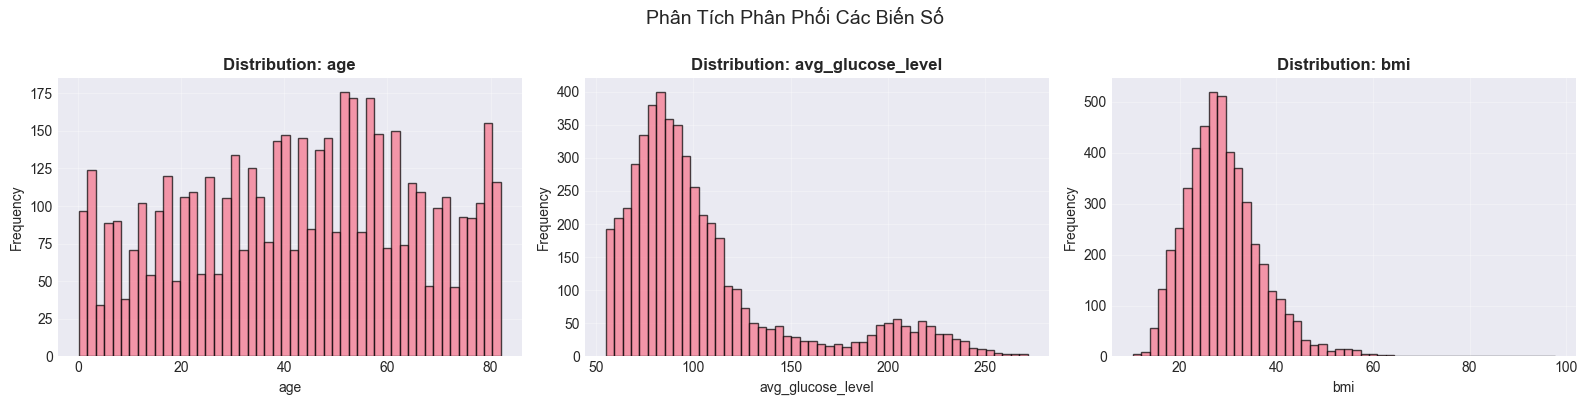

✅ Đã lưu biểu đồ phân phối: distribution_analysis.png


In [194]:
# Thiết lập style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Tạo figure lớn
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Phân Tích Phân Phối Các Biến Số', fontsize=14, y=1)

# Plot distribution của các numeric features
numeric_features = ['age', 'avg_glucose_level', 'bmi']
for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    
    # Histogram
    ax.hist(df[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Đã lưu biểu đồ phân phối: distribution_analysis.png")

PHÂN TÍCH TƯƠNG QUAN

Tương quan với Target (stroke):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
ever_married         0.108340
bmi                  0.036110
smoking_status       0.028123
Residence_type       0.015458
gender               0.008929
id                   0.006388
work_type           -0.032316
Name: stroke, dtype: float64


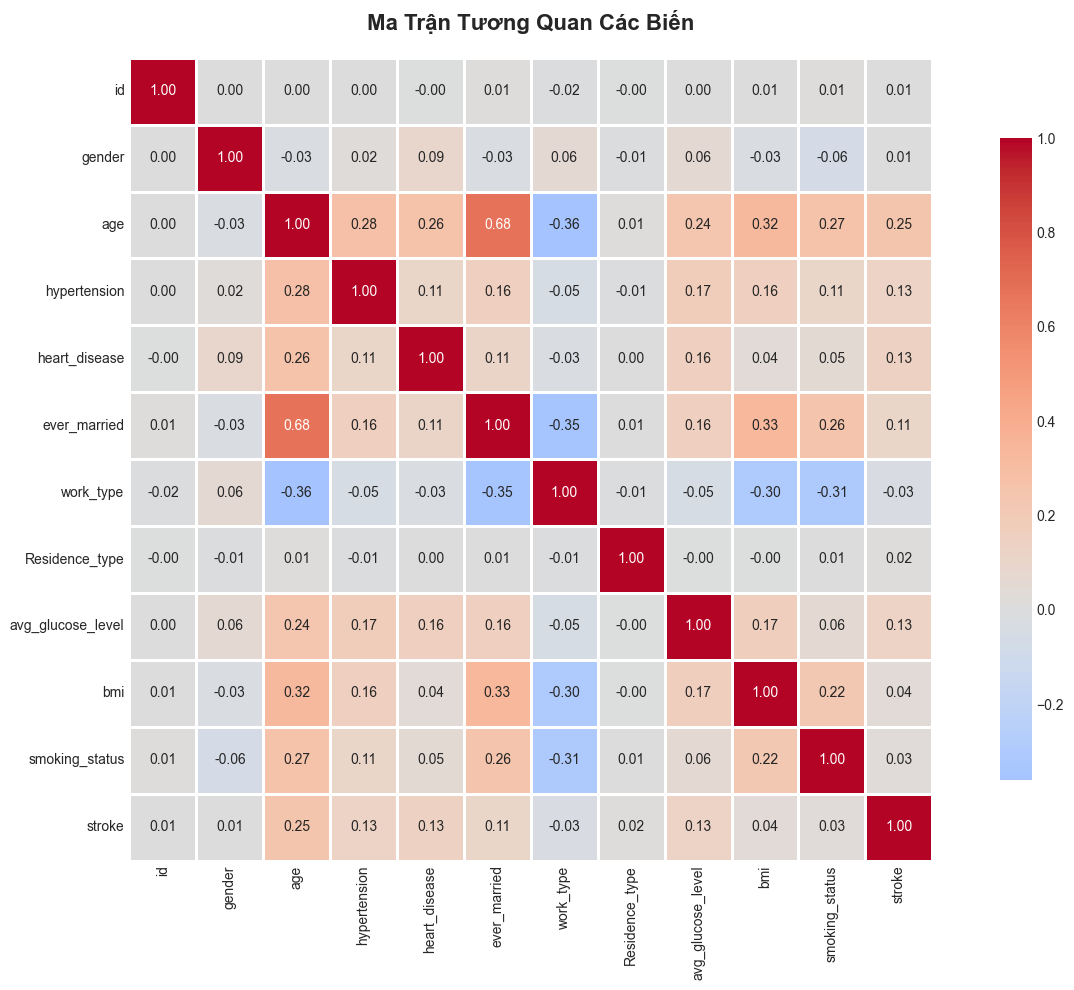


✅ Đã lưu ma trận tương quan: correlation_matrix.png


In [195]:
# Correlation matrix
print("="*80)
print("PHÂN TÍCH TƯƠNG QUAN")
print("="*80)

# Chuẩn bị dữ liệu cho correlation
df_corr = df.copy()

# Encode categorical variables cho correlation
label_encoders = {}
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in cat_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))
    label_encoders[col] = le

# Xử lý bmi (thay 'N/A' bằng NaN rồi fillna với median)
df_corr['bmi'] = pd.to_numeric(df_corr['bmi'], errors='coerce')
df_corr['bmi'].fillna(df_corr['bmi'].median(), inplace=True)

# Tính correlation với target
correlation_with_target = df_corr.corr()['stroke'].sort_values(ascending=False)
print("\nTương quan với Target (stroke):")
print(correlation_with_target)

# Vẽ correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma Trận Tương Quan Các Biến', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Đã lưu ma trận tương quan: correlation_matrix.png")

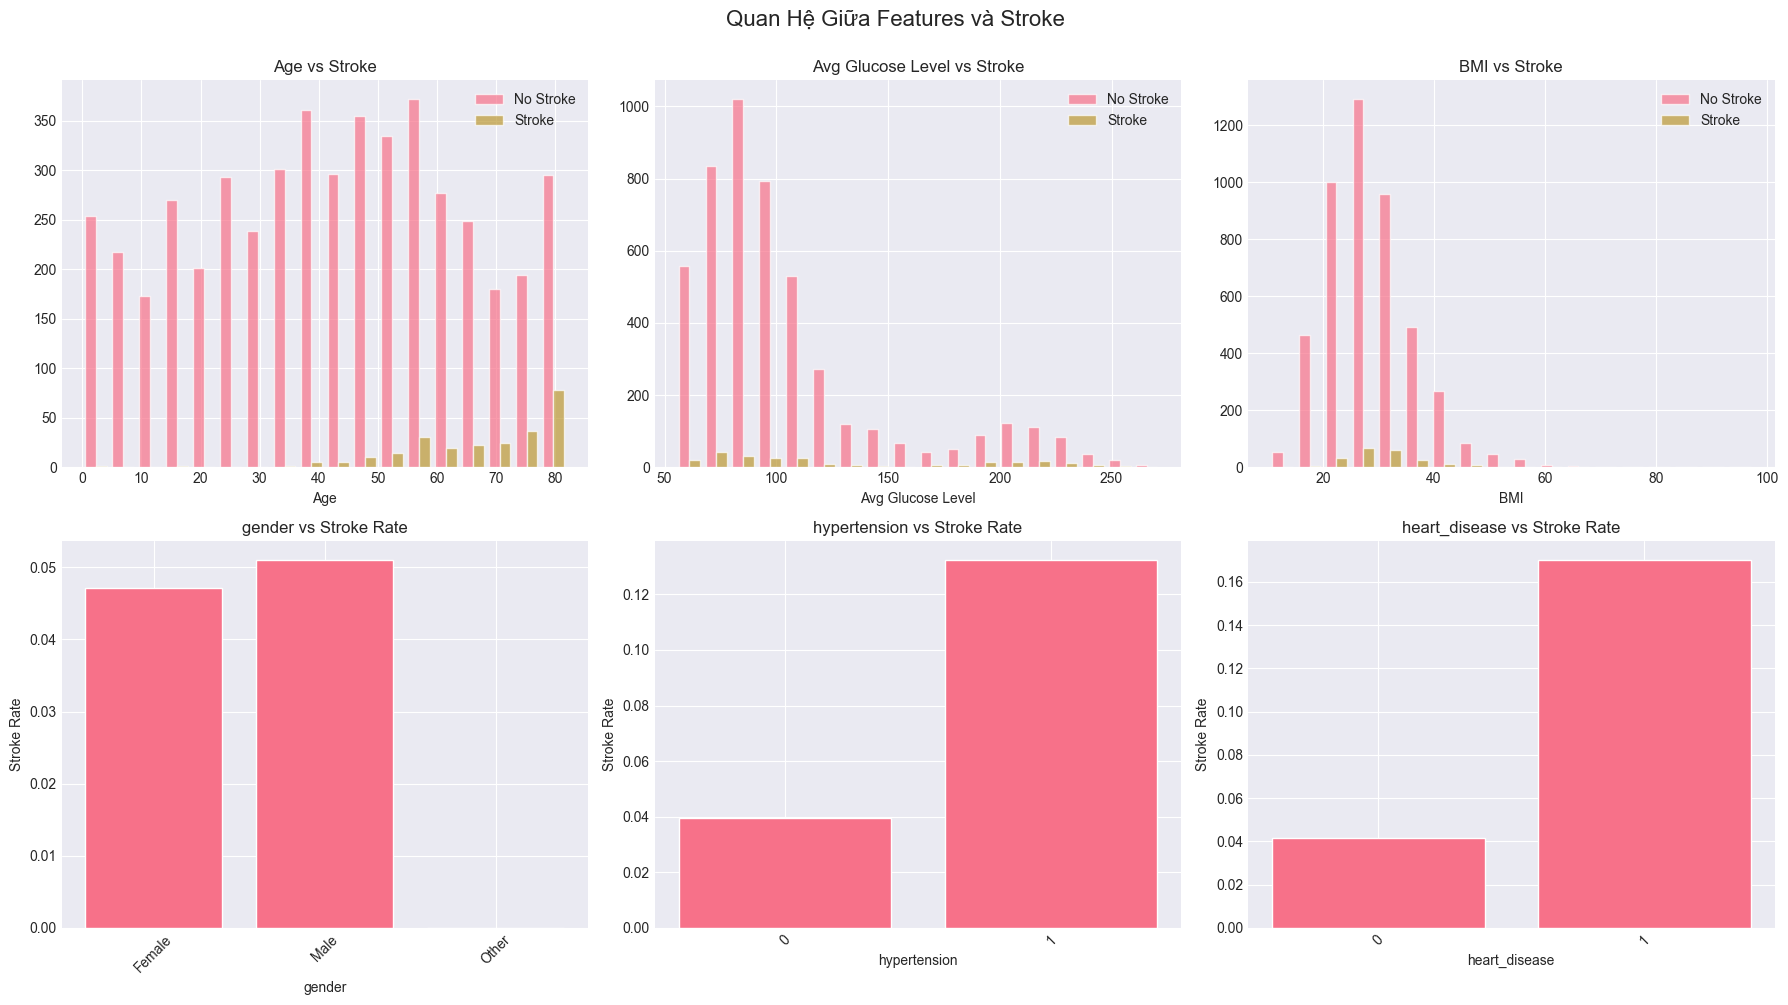

✅ Đã lưu biểu đồ quan hệ: feature_target_relationship.png


In [196]:
# Phân tích quan hệ giữa features và target
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Quan Hệ Giữa Features và Stroke', fontsize=16, y=1.00)

# Age vs Stroke
axes[0, 0].hist([df[df['stroke']==0]['age'], df[df['stroke']==1]['age']], 
                bins=18, label=['No Stroke', 'Stroke'], alpha=0.7)
axes[0, 0].set_title('Age vs Stroke')
axes[0, 0].set_xlabel('Age')
axes[0, 0].legend()

# Avg Glucose Level vs Stroke
axes[0, 1].hist([df[df['stroke']==0]['avg_glucose_level'], df[df['stroke']==1]['avg_glucose_level']], 
                bins=18, label=['No Stroke', 'Stroke'], alpha=0.7)
axes[0, 1].set_title('Avg Glucose Level vs Stroke')
axes[0, 1].set_xlabel('Avg Glucose Level')
axes[0, 1].legend()

# BMI vs Stroke (loại bỏ N/A)
bmi_data = pd.to_numeric(df['bmi'], errors='coerce')
axes[0, 2].hist([bmi_data[df['stroke']==0].dropna(), bmi_data[df['stroke']==1].dropna()], 
                bins=18, label=['No Stroke', 'Stroke'], alpha=0.7)
axes[0, 2].set_title('BMI vs Stroke')
axes[0, 2].set_xlabel('BMI')
axes[0, 2].legend()

# Categorical features
cat_features = ['gender', 'hypertension', 'heart_disease']
for idx, feature in enumerate(cat_features):
    stroke_rate = df.groupby(feature)['stroke'].mean()
    axes[1, idx].bar(range(len(stroke_rate)), stroke_rate.values)
    axes[1, idx].set_title(f'{feature} vs Stroke Rate')
    axes[1, idx].set_xlabel(feature)
    axes[1, idx].set_ylabel('Stroke Rate')
    axes[1, idx].set_xticks(range(len(stroke_rate)))
    axes[1, idx].set_xticklabels(stroke_rate.index, rotation=45)

plt.tight_layout()
plt.savefig('feature_target_relationship.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Đã lưu biểu đồ quan hệ: feature_target_relationship.png")

## Data Cleaning Pipeline

In [197]:
# DATA CLEANING PIPELINE
print("="*80)
print("BẮT ĐẦU XỬ LÝ DỮ LIỆU")
print("="*80)

# Tạo bản copy để xử lý
df_cleaned = df.copy()

# 1. Xử lý cột 'id' - không cần thiết cho model
print("\n1. Loại bỏ cột 'id'...")
df_cleaned = df_cleaned.drop("id", axis=1)
print("   ✅ Đã loại bỏ cột 'id'")

# 2. Xử lý BMI
print("\n2. Xử lý cột 'bmi'...")
# Thay thế 'N/A' string bằng NaN
df_cleaned['bmi'] = pd.to_numeric(df_cleaned['bmi'], errors='coerce')
bmi_missing_count = df_cleaned['bmi'].isnull().sum()
print(f"   Missing values: {bmi_missing_count} ({bmi_missing_count/len(df_cleaned)*100:.2f}%)")

# Impute bằng median theo nhóm age và gender
print("   Imputing bằng median theo nhóm age và gender...")
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[0, 18, 35, 50, 65, 100], 
                                 labels=['0-18', '18-35', '35-50', '50-65', '65+'])

for age_group in df_cleaned['age_group'].unique():
    for gender in df_cleaned['gender'].unique():
        mask = (df_cleaned['age_group'] == age_group) & (df_cleaned['gender'] == gender)
        median_bmi = df_cleaned.loc[mask, 'bmi'].median()
        if pd.notna(median_bmi):
            df.loc[mask & df['bmi'].isnull(), 'bmi'] = median_bmi

# Nếu vẫn còn missing, fill bằng median tổng thể
df_cleaned['bmi'].fillna(df_cleaned['bmi'].median(), inplace=True)
df_cleaned = df_cleaned.drop('age_group', axis=1)
print(f"   ✅ Đã xử lý BMI, còn lại {df_cleaned['bmi'].isnull().sum()} missing values")

# 3. Xử lý các cột categorical
print("\n3. Xử lý các cột categorical...")

# Gender: loại bỏ 'Other' nếu quá ít (< 1%)
gender_counts = df_cleaned['gender'].value_counts()
print(f"   Gender distribution: {dict(gender_counts)}")
if 'Other' in gender_counts.index and gender_counts['Other'] < len(df_cleaned) * 0.01:
    print("   Loại bỏ 'Other' gender (< 1%)...")
    df_cleaned = df_cleaned[df_cleaned['gender'] != 'Other']
    print(f"   ✅ Còn lại {len(df_cleaned)} dòng")
    
# Smoking_status: xử lý 'Unknown'
smoking_counts = df_cleaned['smoking_status'].value_counts()
print(f"\n   Smoking status distribution: {dict(smoking_counts)}")
# Giữ nguyên 'Unknown' vì nó có ý nghĩa (thông tin không rõ)

print("\n   ✅ Đã xử lý các cột categorical")

# 4. Xử lý outliers
print("\n4. Xử lý outliers...")

# Glucose level: giá trị hợp lý 50-300
glucose_outliers = ((df_cleaned['avg_glucose_level'] < 50) | (df_cleaned['avg_glucose_level'] > 300)).sum()
print(f"   Glucose outliers (< 50 hoặc > 300): {glucose_outliers}")
if glucose_outliers > 0:
    df_cleaned = df_cleaned[(df_cleaned['avg_glucose_level'] >= 50) & (df_cleaned['avg_glucose_level'] <= 300)]
    print(f"   ✅ Đã loại bỏ {glucose_outliers} outliers")

# BMI: giá trị hợp lý 10-60
bmi_outliers = ((df_cleaned['bmi'] < 10) | (df_cleaned['bmi'] > 60)).sum()
print(f"   BMI outliers (< 10 hoặc > 60): {bmi_outliers}")
if bmi_outliers > 0:
    df_cleaned = df_cleaned[(df_cleaned['bmi'] >= 10) & (df_cleaned['bmi'] <= 60)]
    print(f"   ✅ Đã loại bỏ {bmi_outliers} outliers")

# Age: kiểm tra giá trị âm hoặc không hợp lý
age_outliers = ((df_cleaned['age'] < 0) | (df_cleaned['age'] > 120)).sum()
print(f"   Age outliers (< 0 hoặc > 120): {age_outliers}")

print(f"\n✅ Dữ liệu sau khi cleaning: {df_cleaned.shape[0]:,} dòng, {df_cleaned.shape[1]} cột")

BẮT ĐẦU XỬ LÝ DỮ LIỆU

1. Loại bỏ cột 'id'...
   ✅ Đã loại bỏ cột 'id'

2. Xử lý cột 'bmi'...
   Missing values: 201 (3.93%)
   Imputing bằng median theo nhóm age và gender...
   ✅ Đã xử lý BMI, còn lại 0 missing values

3. Xử lý các cột categorical...
   Gender distribution: {'Female': np.int64(2994), 'Male': np.int64(2115), 'Other': np.int64(1)}
   Loại bỏ 'Other' gender (< 1%)...
   ✅ Còn lại 5109 dòng

   Smoking status distribution: {'never smoked': np.int64(1892), 'Unknown': np.int64(1544), 'formerly smoked': np.int64(884), 'smokes': np.int64(789)}

   ✅ Đã xử lý các cột categorical

4. Xử lý outliers...
   Glucose outliers (< 50 hoặc > 300): 0
   BMI outliers (< 10 hoặc > 60): 13
   ✅ Đã loại bỏ 13 outliers
   Age outliers (< 0 hoặc > 120): 0

✅ Dữ liệu sau khi cleaning: 5,096 dòng, 11 cột


In [198]:
print("\n" + "="*80)
print("KIỂM TRA CHẤT LƯỢNG SAU KHI CLEANING")
print("="*80)
print(f"Missing values còn lại:")
print(df_cleaned.isnull().sum()[df_cleaned.isnull().sum() > 0])
print(f"\nPhân phối target sau cleaning:")
print(df_cleaned['stroke'].value_counts())
print(f"Imbalance ratio: {df_cleaned['stroke'].value_counts()[0] / df_cleaned['stroke'].value_counts()[1]:.2f}:1")


KIỂM TRA CHẤT LƯỢNG SAU KHI CLEANING
Missing values còn lại:
Series([], dtype: int64)

Phân phối target sau cleaning:
stroke
0    4847
1     249
Name: count, dtype: int64
Imbalance ratio: 19.47:1


## Feature Engineering & Encoding

In [199]:
# FEATURE ENGINEERING
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

df_engineered = df_cleaned.copy()

# 1. Tạo feature tương tác
print("\n1. Tạo các features tương tác...")

# Age groups
df_engineered['age_group'] = pd.cut(df_engineered['age'], 
                                      bins=[0, 30, 50, 70, 100],
                                      labels=['Young', 'Middle', 'Senior', 'Elderly'])

# BMI categories (WHO classification)
df_engineered['bmi_category'] = pd.cut(df_engineered['bmi'],
                                        bins=[0, 18.5, 25, 30, 100],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Glucose level categories
df_engineered['glucose_category'] = pd.cut(df_engineered['avg_glucose_level'],
                                            bins=[0, 100, 126, 300],
                                            labels=['Normal', 'Prediabetes', 'Diabetes'])

# Health risk score
df_engineered['health_risk_score'] = (
    df_engineered['hypertension'] * 2 + 
    df_engineered['heart_disease'] * 3 + 
    (df_engineered['age'] > 60).astype(int) * 2 +
    (df_engineered['avg_glucose_level'] > 126).astype(int) * 2 +
    (df_engineered['bmi'] > 30).astype(int)
)

# Age x glucose interaction
df_engineered['age_glucose_interaction'] = df_engineered['age'] * df_engineered['avg_glucose_level'] / 100

# Age x BMI interaction
df_engineered['age_bmi_interaction'] = df_engineered['age'] * df_engineered['bmi'] / 100

print("   ✅ Đã tạo 7 features mới")

# 2. Encoding categorical variables
print("\n2. Encoding categorical variables...")

# Binary encoding
binary_cols = {
    'gender': {'Male': 1, 'Female': 0},
    'ever_married': {'Yes': 1, 'No': 0},
    'Residence_type': {'Urban': 1, 'Rural': 0}
}

for col, mapping in binary_cols.items():
    df_engineered[col] = df_engineered[col].map(mapping)
    print(f"   ✅ {col}: Binary encoded")

# One-hot encoding cho work_type
print("\n   One-hot encoding 'work_type'...")
work_type_dummies = pd.get_dummies(df_engineered['work_type'], prefix='work', drop_first=True)
df_engineered = pd.concat([df_engineered, work_type_dummies], axis=1)
df_engineered = df_engineered.drop('work_type', axis=1)
print(f"   ✅ Tạo {len(work_type_dummies.columns)} dummy variables")

# One-hot encoding cho smoking_status
print("\n   One-hot encoding 'smoking_status'...")
smoking_dummies = pd.get_dummies(df_engineered['smoking_status'], prefix='smoking', drop_first=True)
df_engineered = pd.concat([df_engineered, smoking_dummies], axis=1)
df_engineered = df_engineered.drop('smoking_status', axis=1)
print(f"   ✅ Tạo {len(smoking_dummies.columns)} dummy variables")

# One-hot encoding cho các category features đã tạo
print("\n   One-hot encoding category features...")
for col in ['age_group', 'bmi_category', 'glucose_category']:
    dummies = pd.get_dummies(df_engineered[col], prefix=col, drop_first=True)
    df_engineered = pd.concat([df_engineered, dummies], axis=1)
    df_engineered = df_engineered.drop(col, axis=1)
    print(f"   ✅ {col}: {len(dummies.columns)} dummy variables")

print(f"\n✅ Feature engineering hoàn tất: {df_engineered.shape[1]} features")
print(f"   Features: {list(df_engineered.columns)}")

FEATURE ENGINEERING

1. Tạo các features tương tác...
   ✅ Đã tạo 7 features mới

2. Encoding categorical variables...
   ✅ gender: Binary encoded
   ✅ ever_married: Binary encoded
   ✅ Residence_type: Binary encoded

   One-hot encoding 'work_type'...
   ✅ Tạo 4 dummy variables

   One-hot encoding 'smoking_status'...
   ✅ Tạo 3 dummy variables

   One-hot encoding category features...
   ✅ age_group: 3 dummy variables
   ✅ bmi_category: 3 dummy variables
   ✅ glucose_category: 2 dummy variables

✅ Feature engineering hoàn tất: 27 features
   Features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'health_risk_score', 'age_glucose_interaction', 'age_bmi_interaction', 'work_Never_worked', 'work_Private', 'work_Self-employed', 'work_children', 'smoking_formerly smoked', 'smoking_never smoked', 'smoking_smokes', 'age_group_Middle', 'age_group_Senior', 'age_group_Elderly', 'bmi_category_Normal', 'bmi_category_Ove

## Train/Validation/Test Split & Normalization

In [200]:
# Tạo thư mục nếu chưa tồn tại
print("="*80)
print("CHIA DỮ LIỆU & CHUẨN HÓA")
print("="*80)

# Tách features và target
X = df_engineered.drop('stroke', axis=1)
y = df_engineered['stroke']

print(f"\nShape trước khi chia:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"y distribution: {dict(y.value_counts())}")

# Chia train/test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Chia train/validation từ tập temp (75/25 của temp = 60/20 của tổng)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nShape sau khi chia:")
print(f"Train: X={X_train.shape}, y={y_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   X={X_val.shape}, y={y_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  X={X_test.shape}, y={y_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nPhân phối target:")
print(f"Train: {dict(y_train.value_counts())}")
print(f"Val:   {dict(y_val.value_counts())}")
print(f"Test:  {dict(y_test.value_counts())}")


CHIA DỮ LIỆU & CHUẨN HÓA

Shape trước khi chia:
X: (5096, 26)
y: (5096,)
y distribution: {0: np.int64(4847), 1: np.int64(249)}

Shape sau khi chia:
Train: X=(3057, 26), y=(3057,) (60.0%)
Val:   X=(1019, 26), y=(1019,) (20.0%)
Test:  X=(1020, 26), y=(1020,) (20.0%)

Phân phối target:
Train: {0: np.int64(2908), 1: np.int64(149)}
Val:   {0: np.int64(969), 1: np.int64(50)}
Test:  {0: np.int64(970), 1: np.int64(50)}


In [201]:
# Chuẩn hóa dữ liệu (StandardScaler)
print("\n" + "="*80)
print("CHUẨN HÓA DỮ LIỆU (STANDARDIZATION)")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert về DataFrame để giữ tên cột
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Đã chuẩn hóa dữ liệu với StandardScaler")
print(f"   Mean train: {X_train_scaled.mean().mean():.6f}")
print(f"   Std train: {X_train_scaled.std().mean():.6f}")

# Xử lý imbalance với SMOTE (chỉ trên tập train)
print("\n" + "="*80)
print("XỬ LÝ IMBALANCED DATA VỚI SMOTE")
print("="*80)

print(f"Trước SMOTE: {dict(y_train.value_counts())}")
print(f"Imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nSau SMOTE: {dict(pd.Series(y_train_resampled).value_counts())}")
print(f"Imbalance ratio: 1:1 (balanced)")
print(f"Tăng từ {len(X_train_scaled)} lên {len(X_train_resampled)} samples")

# Convert về DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
y_train_resampled = pd.Series(y_train_resampled, name='stroke')

print("\n✅ Hoàn tất xử lý imbalanced data")


CHUẨN HÓA DỮ LIỆU (STANDARDIZATION)
✅ Đã chuẩn hóa dữ liệu với StandardScaler
   Mean train: 0.000000
   Std train: 1.000164

XỬ LÝ IMBALANCED DATA VỚI SMOTE
Trước SMOTE: {0: np.int64(2908), 1: np.int64(149)}
Imbalance ratio: 19.52:1

Sau SMOTE: {0: np.int64(2908), 1: np.int64(2908)}
Imbalance ratio: 1:1 (balanced)
Tăng từ 3057 lên 5816 samples

✅ Hoàn tất xử lý imbalanced data


## Lưu Dữ Liệu Đã Xử Lý

In [205]:
# Lưu các file đã xử lý
processed_dir = data_dir / "processed"
processed_dir.mkdir(exist_ok=True)
feature_names = list(X_train.columns) # Lấy tên cột gốc

print("="*80)
print("LƯU DỮ LIỆU ĐÃ XỬ LÝ")
print("="*80)

# --- 1. Lưu dữ liệu đã Balanced (Dùng để Train model chính) ---
# Reset index để tránh lỗi lệch dòng khi concat
train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
train_resampled.to_csv(processed_dir / 'train_balanced.csv', index=False)
print(f"✅ Đã lưu: train_balanced.csv ({train_resampled.shape})")

# --- 2. Lưu dữ liệu Scaled gốc (Dùng để so sánh/reference) ---
train_scaled = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_scaled.to_csv(processed_dir / 'train_scaled.csv', index=False)
print(f"✅ Đã lưu: train_scaled.csv ({train_scaled.shape})")

# --- 3. Lưu Validation set (Dùng để Tuning Hyperparameters) ---
val_scaled = pd.concat([X_val_scaled.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
val_scaled.to_csv(processed_dir / 'validation.csv', index=False)
print(f"✅ Đã lưu: validation.csv ({val_scaled.shape})")

# --- 4. Lưu Test set (Dùng để đánh giá cuối cùng - Final Evaluation) ---
test_scaled = pd.concat([X_test_scaled.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_scaled.to_csv(processed_dir / 'test.csv', index=False)
print(f"✅ Đã lưu: test.csv ({test_scaled.shape})")

# --- 5. Lưu Scaler (Quan trọng để scale dữ liệu mới sau này) ---
joblib.dump(scaler, processed_dir / 'scaler.pkl')
print(f"✅ Đã lưu: scaler.pkl")

# --- 6. Lưu danh sách Feature Names ---
# Giúp đảm bảo thứ tự cột khi dự đoán dữ liệu mới
with open(processed_dir / 'feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")
print(f"✅ Đã lưu: feature_names.txt ({len(feature_names)} features)")

# --- 7. Lưu Data Info (Metadata) ---
# SỬA LỖI: Thêm encoding='utf-8' để hỗ trợ tiếng Việt
with open(processed_dir / 'data_info.txt', 'w', encoding='utf-8') as f:
    f.write("THÔNG TIN DỮ LIỆU ĐÃ XỬ LÝ\n")
    f.write("="*80 + "\n\n")
    f.write(f"Original data shape: {df.shape}\n")
    f.write(f"Cleaned data shape: {df_cleaned.shape}\n")
    f.write(f"Final feature count: {len(feature_names)}\n\n")
    f.write("-" * 20 + " DATASETS " + "-" * 20 + "\n")
    f.write(f"Train (Balanced - SMOTE): {train_resampled.shape}\n")
    f.write(f"Train (Original Scaled):  {train_scaled.shape}\n")
    f.write(f"Validation:               {val_scaled.shape}\n")
    f.write(f"Test:                     {test_scaled.shape}\n\n")
    f.write("-" * 20 + " SETTINGS " + "-" * 20 + "\n")
    f.write(f"Scaler: StandardScaler\n")
    f.write(f"Resampling: SMOTE (Train set only)\n")

print(f"✅ Đã lưu: data_info.txt")
print("\n🎉 Hoàn tất quá trình lưu dữ liệu!")

LƯU DỮ LIỆU ĐÃ XỬ LÝ
✅ Đã lưu: train_balanced.csv ((5816, 27))
✅ Đã lưu: train_scaled.csv ((3057, 27))
✅ Đã lưu: validation.csv ((1019, 27))
✅ Đã lưu: test.csv ((1020, 27))
✅ Đã lưu: scaler.pkl
✅ Đã lưu: feature_names.txt (26 features)
✅ Đã lưu: data_info.txt

🎉 Hoàn tất quá trình lưu dữ liệu!
